# 6-Data-Mining Algorithm(s) Selection

# OBJ 1 - Random Forest Classifier model 

In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierCV").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col).fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target")

# Create a parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Set up the cross-validator
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                                 numFolds=4,  # We can adjust the number of folds as needed
                                 seed=42)

# Run cross-validation and choose the best set of parameters
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set using the best model
cv_predictions = cv_model.transform(test_data)

# Evaluate the model
cv_accuracy = evaluator.evaluate(cv_predictions)

# Print the results
print("Best Area under ROC after Cross-Validation = {}".format(cv_accuracy))

# Stop the Spark session
spark.stop()


Best Area under ROC after Cross-Validation = 0.8137707306918326


23/10/08 00:21:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


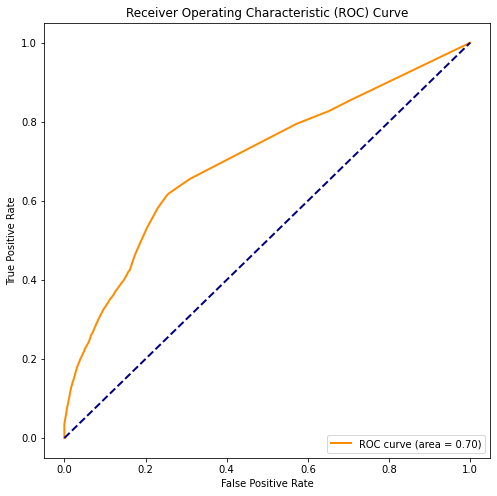

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestClassifierCV").getOrCreate()

# Load data
csv_file_path = 'Merged-data.csv'
df = spark.read.format("csv").option("header", "true").load(csv_file_path)

# Using Binary target variable (1 or 0)
# If 'ClientsSeenRate' > threshold, set 'Target' to 1; otherwise, set it to 0.
threshold = 200
df = df.withColumn('Target', (df['ClientsSeenRate'] > threshold).cast("integer"))

# Select the features and target variable
selected_cols = ['Gender', 'AgeGroup', 'Ethnicity']
feature_cols = ['encoded_' + col for col in selected_cols]

# Encode categorical variables (Gender, AgeGroup, Ethnicity)
indexers = [StringIndexer(inputCol=col, outputCol='encoded_' + col).fit(df) for col in selected_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Target")

# Create a parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Set up the cross-validator
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                                 numFolds=4,  # We can adjust the number of folds as needed
                                 seed=42)

# Run cross-validation and choose the best set of parameters
cv_model = cross_validator.fit(train_data)

# Make predictions on the test set using the best model
cv_predictions = cv_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
cv_accuracy = evaluator.evaluate(cv_predictions)

# Plot the ROC curve
def plot_roc_curve(predictions, label_col='Target', raw_prediction_col='rawPrediction'):
    y_true = [row[label_col] for row in predictions.select(label_col).collect()]
    y_scores = [row[raw_prediction_col][1] for row in predictions.select(raw_prediction_col).collect()]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot the ROC curve for the cross-validated model
plot_roc_curve(cv_predictions)




In [22]:
confusion_matrix = cv_predictions.groupBy("Target", "prediction").count()
confusion_matrix.show()


+------+----------+-----+
|Target|prediction|count|
+------+----------+-----+
|     1|       0.0|10097|
|     0|       0.0|45613|
|     1|       1.0| 1296|
|     0|       1.0|  638|
+------+----------+-----+



# OBJ 2 - K-means Clustering

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 00:04:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


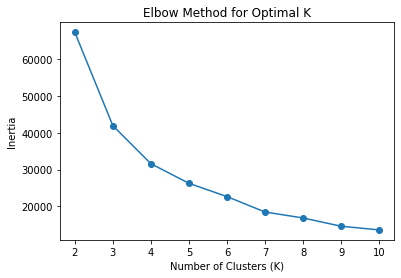

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# Initialize Spark session
spark = SparkSession.builder.appName("ClusterAnalysis").getOrCreate()

# Load data from CSV
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Filter out rows where 'TeamType' is not 'Total'
df = df.filter(col('Team') != 'Total')

# Encode categorical variables
indexer = StringIndexer(inputCol='Team', outputCol='TeamIndex')
df = indexer.fit(df).transform(df)

# Standardize numerical features
numerical_cols = ['ClientsSeen', 'ClientsSeenFaceToFace', 'Contacts']
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(df)
df = model.transform(df)

# Select relevant features for clustering
selected_features = ['TeamIndex', 'scaled_features']
df = df.select(selected_features)

# Determine the optimal number of clusters using the elbow method
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df)
    inertia_values.append(model.summary.trainingCost)

# Plot the elbow method to choose the optimal K
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [2]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Compute silhouette scores for different values of K
for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df)
    predictions = model.transform(df)

    # Convert PySpark DataFrame to Pandas DataFrame
    pandas_predictions = predictions.select('TeamIndex', 'prediction', 'scaled_features').toPandas()

    # Extract relevant columns
    labels = pandas_predictions['prediction']
    
    # Extract values from DenseVectors
    features = np.array([vector.toArray() for vector in pandas_predictions['scaled_features']])

    # Compute silhouette score
    silhouette = silhouette_score(features, labels)
    print(f"For K={k}, Silhouette Score: {silhouette}")

For K=2, Silhouette Score: 0.9350953463596291


For K=3, Silhouette Score: 0.9122309667821634


For K=4, Silhouette Score: 0.9013891116921409


For K=5, Silhouette Score: 0.842274323430666


For K=6, Silhouette Score: 0.8478161218391959


For K=7, Silhouette Score: 0.8471642404473244


For K=8, Silhouette Score: 0.8368858199094544


For K=9, Silhouette Score: 0.8073059668687405


For K=10, Silhouette Score: 0.7913471894360916


In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler

# Choose the optimal number of clusters
optimal_k = 3

# Fit the KMeans model with the chosen K
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42, predictionCol='cluster')

# Create a new instance of the model and fit it
model = kmeans.fit(df)

# Add the 'cluster' column to the original DataFrame
clustered_df = model.transform(df)

# Display the results
clustered_df.select('TeamIndex', 'scaled_features', 'cluster').show()

+---------+--------------------+-------+
|TeamIndex|     scaled_features|cluster|
+---------+--------------------+-------+
|      5.0|[-0.2801231818286...|      0|
|      0.0|[1.12158384180993...|      0|
|      1.0|[-0.2531116218410...|      0|
|      7.0|[-0.2849466746835...|      0|
|      2.0|[-0.2068060904339...|      0|
|     10.0|[-0.2839819761125...|      0|
|      8.0|[-0.2849466746835...|      0|
|      6.0|[-0.2733702918317...|      0|
|      5.0|[-0.2675821004058...|      0|
|      0.0|[5.82738347106589...|      1|
|      1.0|[-0.2193471718566...|      0|
|      7.0|[-0.2637233061219...|      0|
|      4.0|[-0.2801231818286...|      0|
|      2.0|[0.10286215085169...|      0|
|      8.0|[-0.2810878803996...|      0|
|      6.0|[-0.0621013047864...|      0|
|      5.0|[-0.1170891233324...|      0|
|      0.0|[9.90516433061181...|      1|
|      1.0|[2.21651671987584...|      2|
|      3.0|[-0.0881481662029...|      0|
+---------+--------------------+-------+
only showing top

In [4]:
# Profile the clusters
cluster_profiles = clustered_df.groupBy('cluster').mean()
cluster_profiles.show()

+-------+--------------------+------------+
|cluster|      avg(TeamIndex)|avg(cluster)|
+-------+--------------------+------------+
|      1|0.029900332225913623|         1.0|
|      2|  0.3950381679389313|         2.0|
|      0|   4.702726252115484|         0.0|
+-------+--------------------+------------+



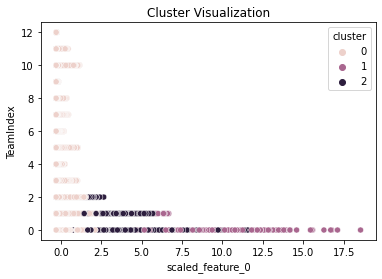

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = clustered_df.toPandas()

# Extract individual components from the DenseVector
for i in range(len(pandas_df['scaled_features'][0])):
    pandas_df[f'scaled_feature_{i}'] = pandas_df['scaled_features'].apply(lambda x: x[i])

# Scatter plot to visualize clusters
sns.scatterplot(x='scaled_feature_0', y='TeamIndex', hue='cluster', data=pandas_df)
plt.title("Cluster Visualization")
plt.show()

In [6]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='cluster', metricName='silhouette')

# Calculate Silhouette score
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.9583707296274857
